In [20]:
%config InlineBackend.figure_format = 'retina'
#setup
data_dir='../../Data/Weather'
file_index='SSSSSSBB'
m='TOBS'

# Reconstruction using top eigen-vectors
For measurement = {{m}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [3]:
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.12.0 	required version>=1.12.0
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [4]:
from pyspark import SparkContext, SparkConf
#sc.stop()
conf = SparkConf()
conf = conf.setAppName("temp1")
conf = conf.setMaster("local")
conf = conf.set("spark.driver.host", "localhost")
sc = SparkContext(conf=conf, master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





## Read Statistics File

In [11]:
data_dir='../../Data/Weather'
file_index='SSSSSSBB'

In [12]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [13]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    371.9| 33.5333|-113.1667|       TOBS|USC00023852|     7|[40 56 E0 50 00 5...|1970.0|SSSSSSBB|
|    371.9| 33.5333|-113.1667|       TOBS|USC00023852|     3|[A0 56 30 55 80 5...|1971.0|SSSSSSBB|
|    371.9| 33.5333|-113.1667|       TOBS|USC00023852|    14|[80 54 A0 53 F0 5...|1973.0|SSSSSSBB|
|    371.9| 33.5333|-113.1667|       TOBS|USC00023852|    10|[40 56 20 50 30 5...|1974.0|SSSSSSBB|
|    371.9| 33.5333|-113.1667|       TOBS|USC00023852|     8|[30 54 30 54 30 5...|1975.0|SSSSSSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Create a matrix with all of the series

In [14]:
rows=df.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()

T=np.vstack(rows)
shape(T)

(1271, 365)

### Plot two time series
`SNWD` stands for `snow-depth`, which explains why it is zero during the summer

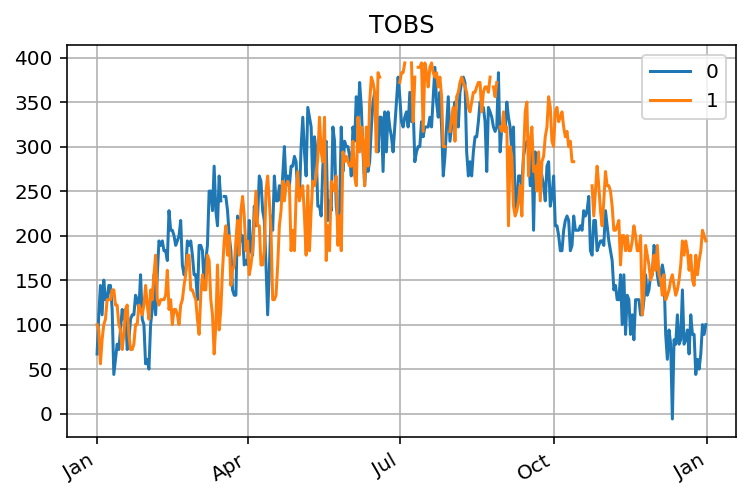

In [21]:
fig, ax = plt.subplots(figsize=(6,4));
YP=YearPlotter()
YP.plot(T[16:18].transpose(),fig,ax,title=m)

### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

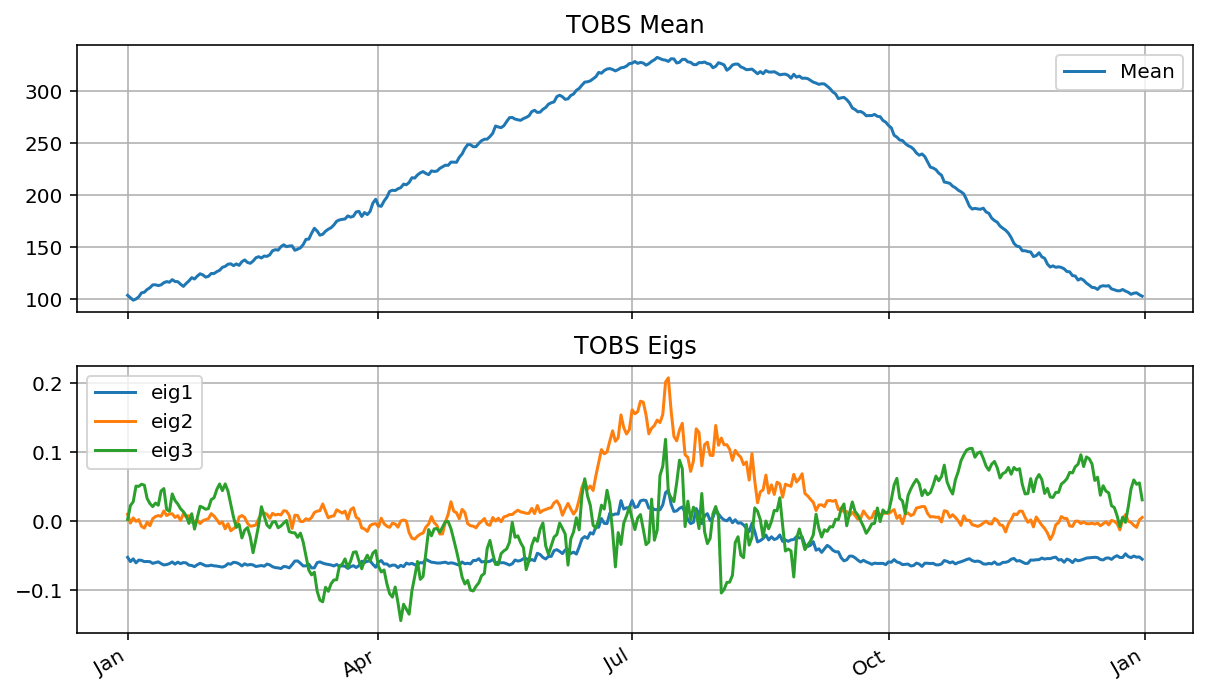

In [71]:
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

### plot the percent of residual variance on average

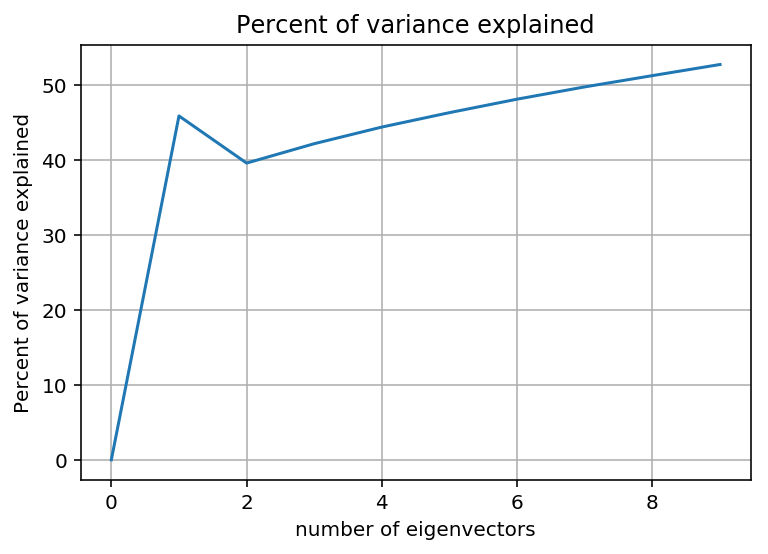

In [23]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

In [24]:
i=10
v=[np.array(EigVec[:,i]).flatten() for i in range(shape(EigVec)[1])]
eigen_decomp=Eigen_decomp(None,T[i],Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

residual normalized norm  after mean: 0.0207355881291
residual normalized norm  after mean + top eigs: [ 0.97795237  1.38788754  1.38740966]


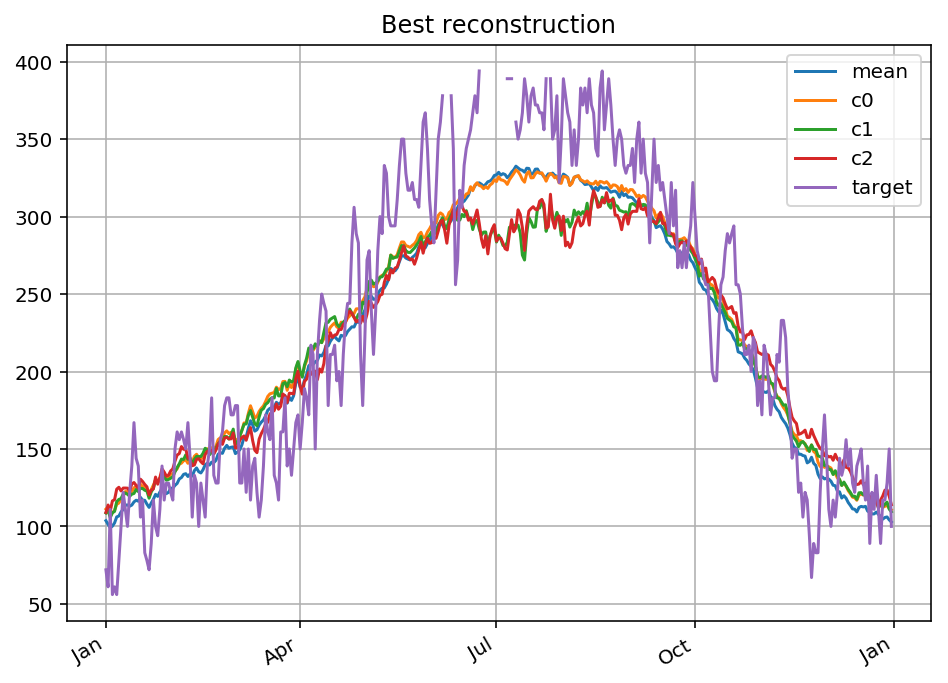

In [25]:
plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

## Process whole dataframe to find best and worse residuals

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [26]:
rows=df.take(3)
L=[]
for row in rows:
    row_out=decompose(row,Mean,v)
    for field in ('res_mean','res_1','res_2','res_3'):
        print field,':',row_out[field],
    print

NameError: name 'decompose' is not defined

In [27]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [28]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

before filter 1271
after filter 1271


In [29]:
df3=df3.sort(df3.res_3,ascending=True)
rows=df3.take(12)


In [55]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=4, row_n=3, figsize=(15,10)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            _title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
                    %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            #print i,j,_title,axes[i,j]
            plot_decomp(row,Mean,v,fig=fig,ax=axes[i,j],Title=_title,interactive=False)
    return None


In [56]:
num=12

In [72]:
df3=df3.sort(df3.res_mean)
rows=df3.take(num)
df3.select('res_mean','res_1','res_2','res_3').show(4)

+--------------------+------------------+------------------+------------------+
|            res_mean|             res_1|             res_2|             res_3|
+--------------------+------------------+------------------+------------------+
|0.014968259086334238|0.9927704011981447| 0.980454000768214|0.9770799097170527|
|0.015136293587410673|0.9943405460000508|0.8766708933384401|0.7686563935284783|
| 0.01697045516537055|0.9735405252953274|0.9749881430931219|0.9749020928035846|
|0.017020159517205008|0.9916795500918875| 0.947459030722567|0.8666391968861791|
+--------------------+------------------+------------------+------------------+
only showing top 4 rows



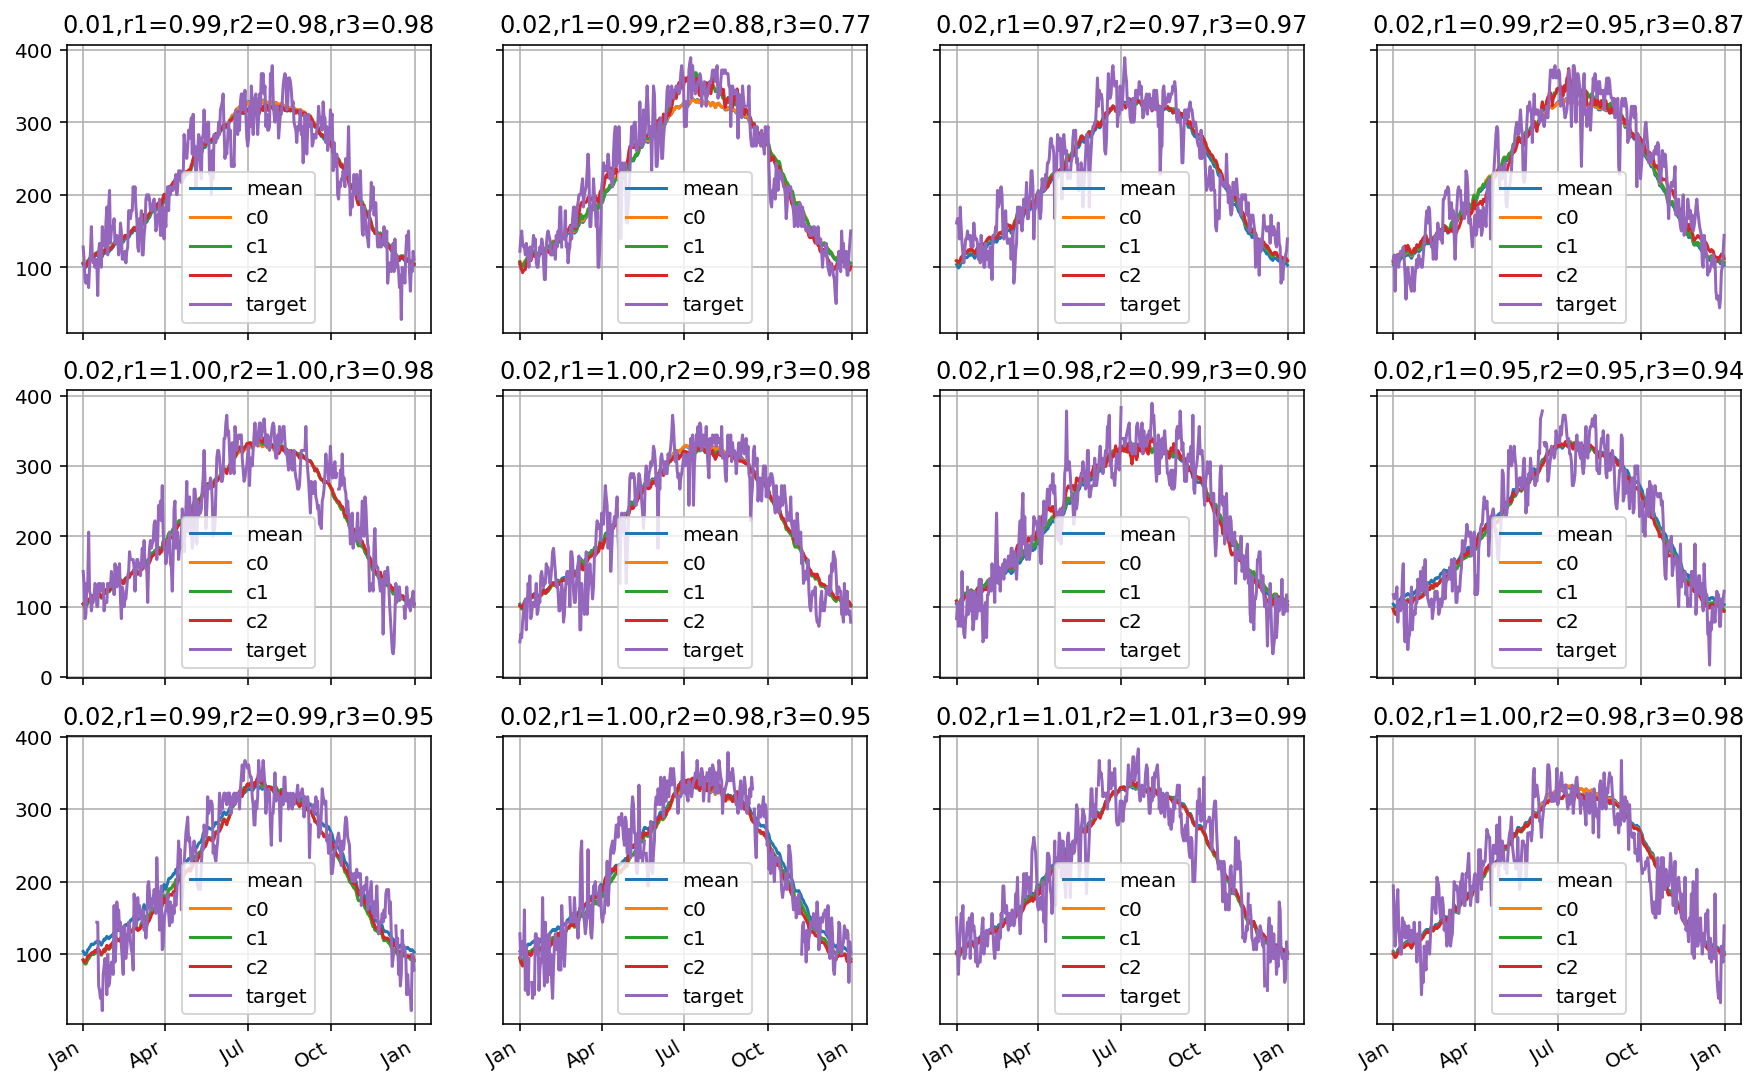

In [73]:
plot_recon_grid(rows)

In [74]:
df3=df3.sort(df3.res_mean,ascending=False)
rows=df3.take(num)
df3.select('res_mean','res_1','res_2','res_3').show(4)

+------------------+------------------+-------------------+-------------------+
|          res_mean|             res_1|              res_2|              res_3|
+------------------+------------------+-------------------+-------------------+
|0.5634220200895198|0.2724742363767796|0.09882593716899182| 0.0975656791209643|
|0.5477635352713006|0.2817150650628105|0.11550670142430124| 0.1152627599177388|
|0.5014709064403187|0.3181001516000303| 0.0706828863563467|0.07050803275944421|
|0.4914939723946366|0.5070642593084506|0.23363216675877002|0.22198256883069953|
+------------------+------------------+-------------------+-------------------+
only showing top 4 rows



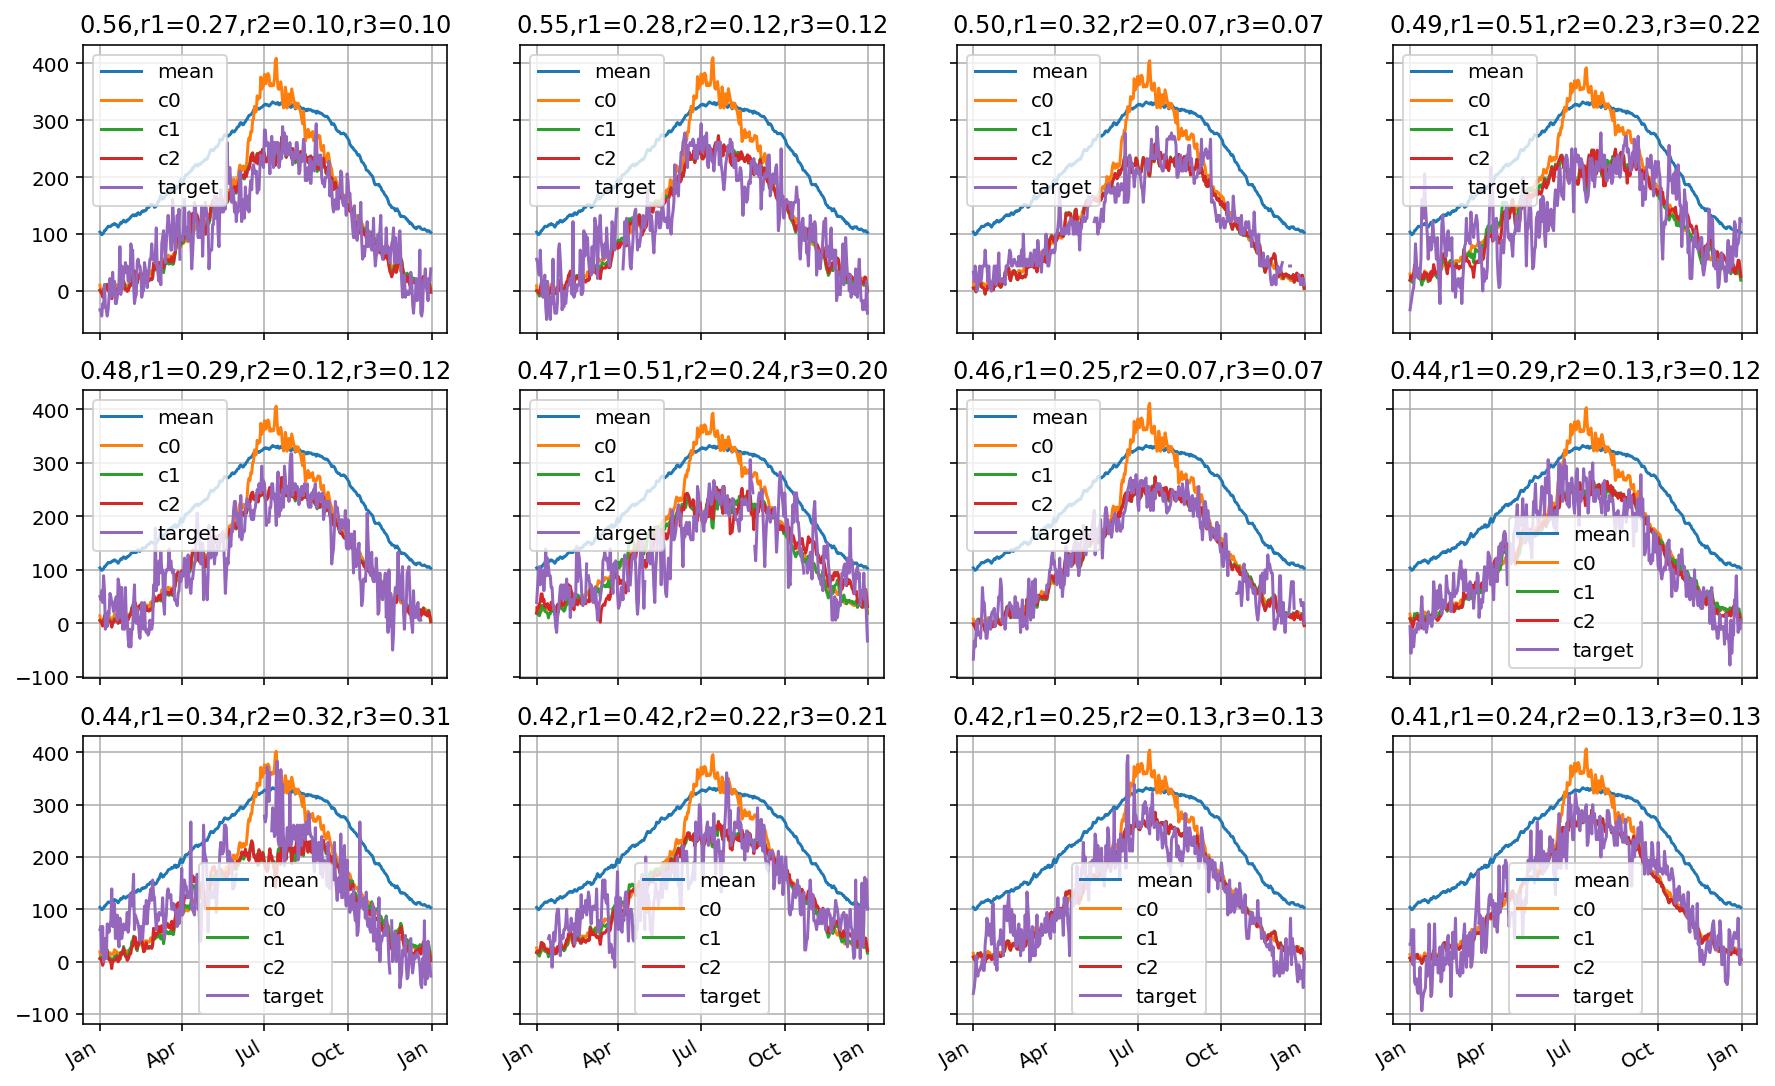

In [75]:
plot_recon_grid(rows)

In [69]:
df3=df3.sort(df3.res_1)
rows=df3.take(num)
df3.select('res_mean','res_1','res_2','res_3').show(4)

+-------------------+-------------------+-------------------+-------------------+
|           res_mean|              res_1|              res_2|              res_3|
+-------------------+-------------------+-------------------+-------------------+
| 0.2448158585390374|0.19888894656509756|0.13872078119482792| 0.1385478118095872|
| 0.3129907604062654|0.20526736970849682|0.22068121239893354|0.22330479599183026|
|0.20952937152063295|0.22407226769797542|0.14877853284989942|0.14875230732240335|
|0.22102245166771517|0.22713588718050667| 0.1734630598356882|0.16981145137960552|
+-------------------+-------------------+-------------------+-------------------+
only showing top 4 rows



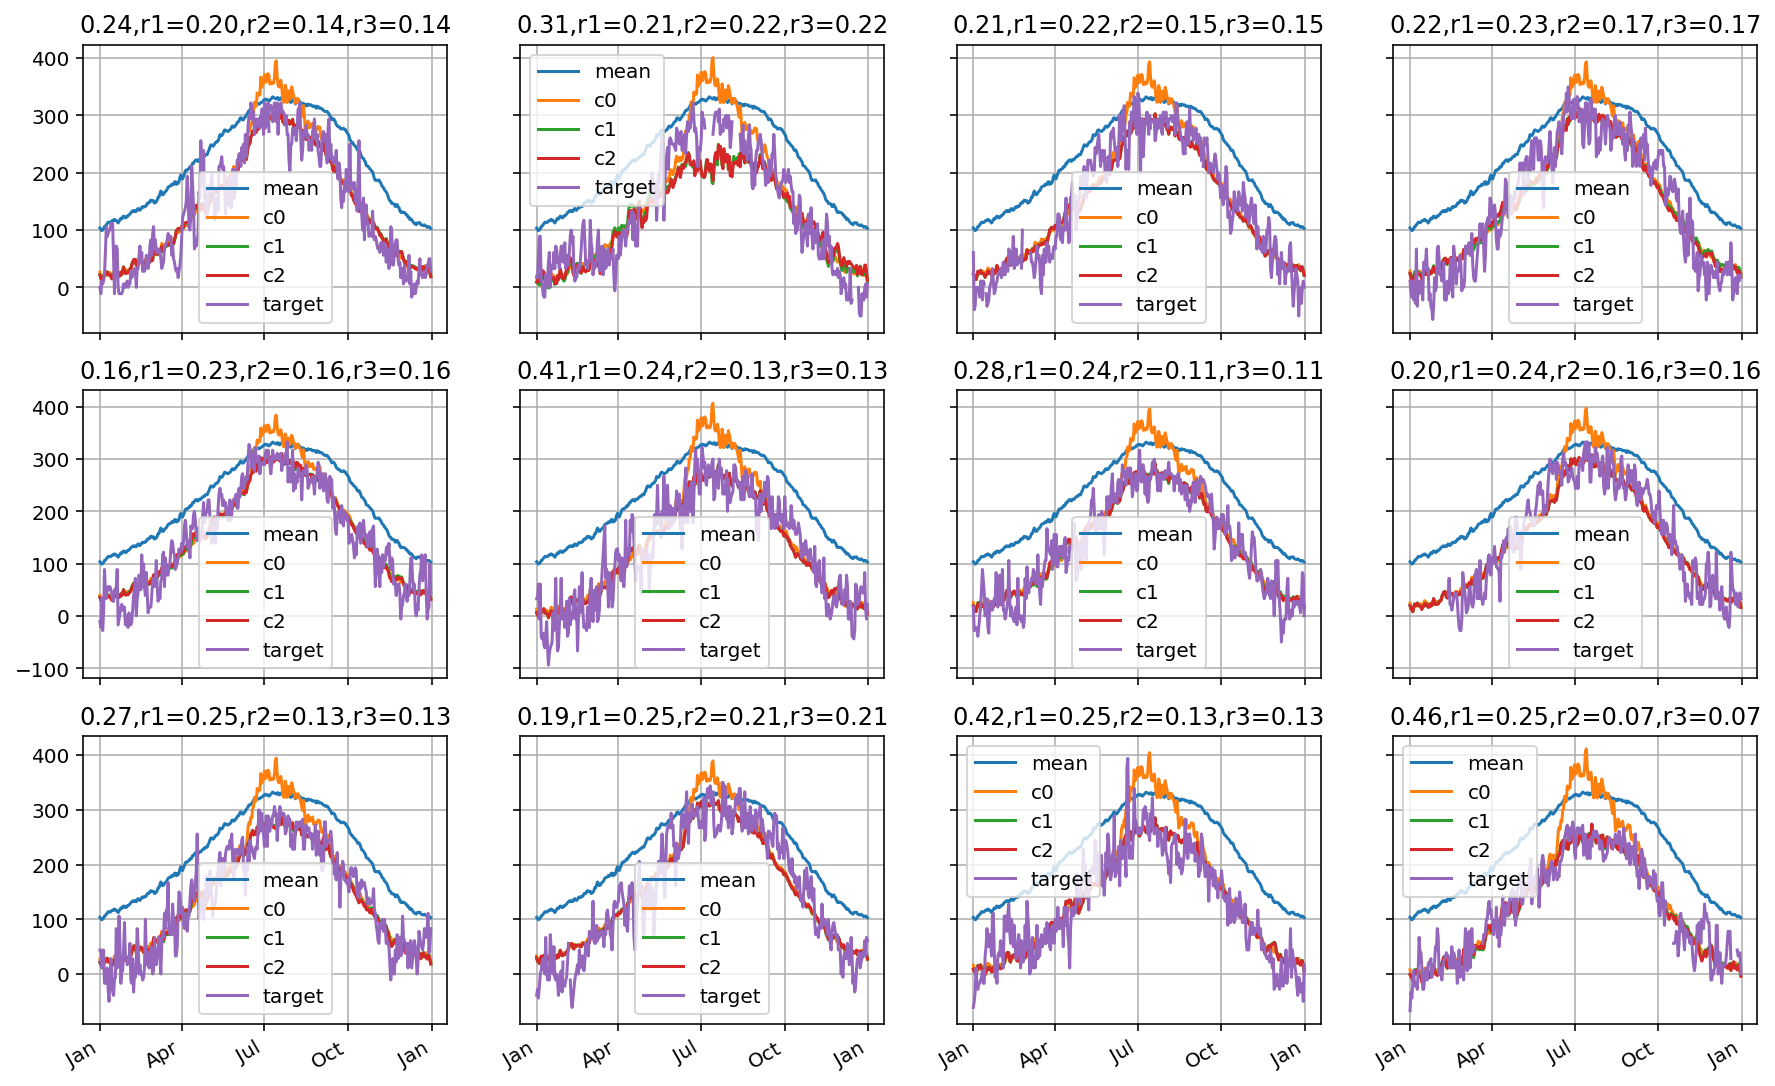

In [70]:
plot_recon_grid(rows)

In [59]:
df3=df3.sort(df3.res_1,ascending=False)
rows=df3.take(num)
df3.select('res_mean','res_1','res_2','res_3').show(4)

+--------------------+------------------+------------------+------------------+
|            res_mean|             res_1|             res_2|             res_3|
+--------------------+------------------+------------------+------------------+
|0.026319104016279366| 1.369438552706775|1.5116428715773418| 1.446759275632921|
|0.026665234975030806| 1.333937378751906|1.3286641656808085|1.4399111183881321|
|0.026347180990659486|1.2702666310996036| 1.272106734247473|1.5086175765146388|
| 0.03429660949553013|1.1610267088613897|1.3705693911423917|1.4578789201182005|
+--------------------+------------------+------------------+------------------+
only showing top 4 rows



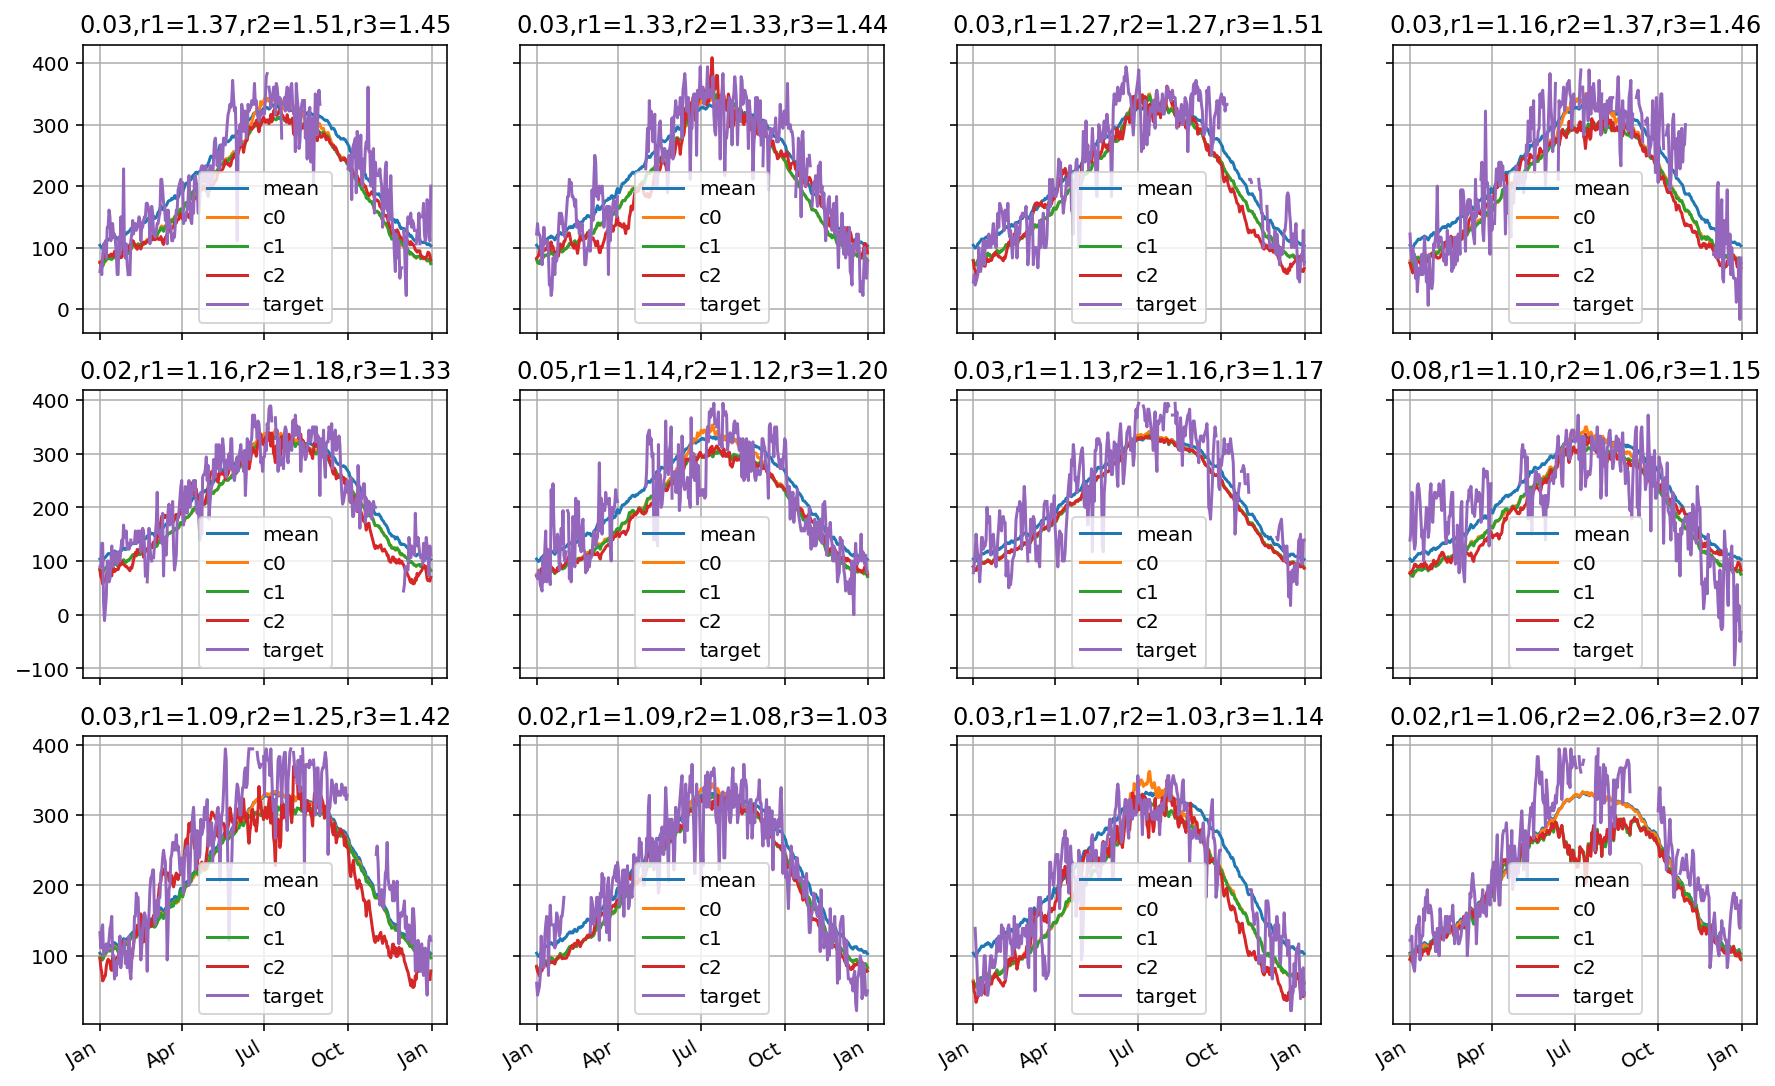

In [60]:
plot_recon_grid(rows)

In [61]:
df3=df3.sort(df3.res_2)
rows=df3.take(num)
df3.select('res_mean','res_1','res_2','res_3').show(4)

+-------------------+-------------------+-------------------+-------------------+
|           res_mean|              res_1|              res_2|              res_3|
+-------------------+-------------------+-------------------+-------------------+
| 0.5014709064403187| 0.3181001516000303| 0.0706828863563467|0.07050803275944421|
|0.45994445270308343|0.25459494543574046| 0.0729429492001073|0.07274134398454164|
| 0.5634220200895198| 0.2724742363767796|0.09882593716899182| 0.0975656791209643|
|0.28487258184791486|0.23816917469148932| 0.1104506019273177|0.10986098504594669|
+-------------------+-------------------+-------------------+-------------------+
only showing top 4 rows



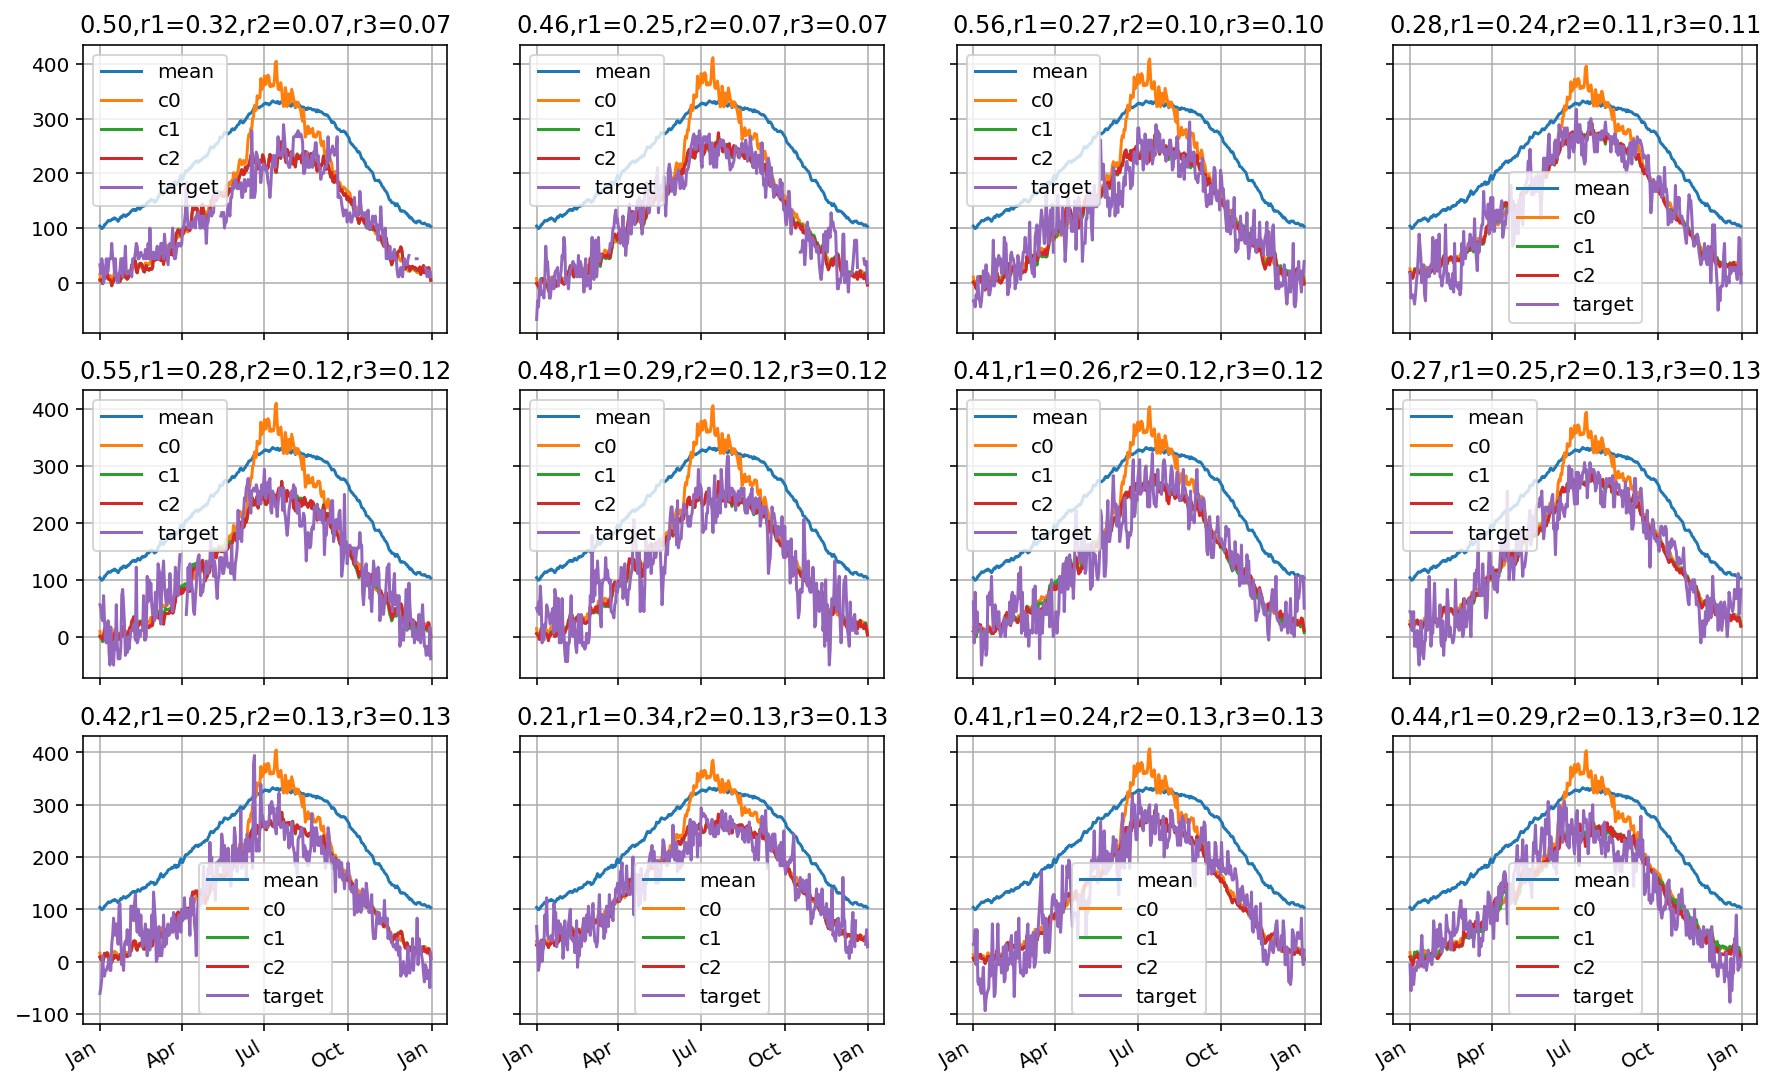

In [62]:
plot_recon_grid(rows)

In [63]:
df3=df3.sort(df3.res_2,ascending=False)
rows=df3.take(num)
df3.select('res_mean','res_1','res_2','res_3').show(4)

+--------------------+------------------+------------------+------------------+
|            res_mean|             res_1|             res_2|             res_3|
+--------------------+------------------+------------------+------------------+
|0.029431963567291518|0.7962757836947854| 2.902176743294988|2.9005965135398957|
| 0.02942615222565886|1.0294528136814287|2.7151853073172387|2.4028059930360315|
|0.031525008520505785|0.8833092175087011|2.5113644996649716| 2.517123061356871|
| 0.02923149864432457|0.7145878585047498| 2.446154082146666| 2.370922946796973|
+--------------------+------------------+------------------+------------------+
only showing top 4 rows



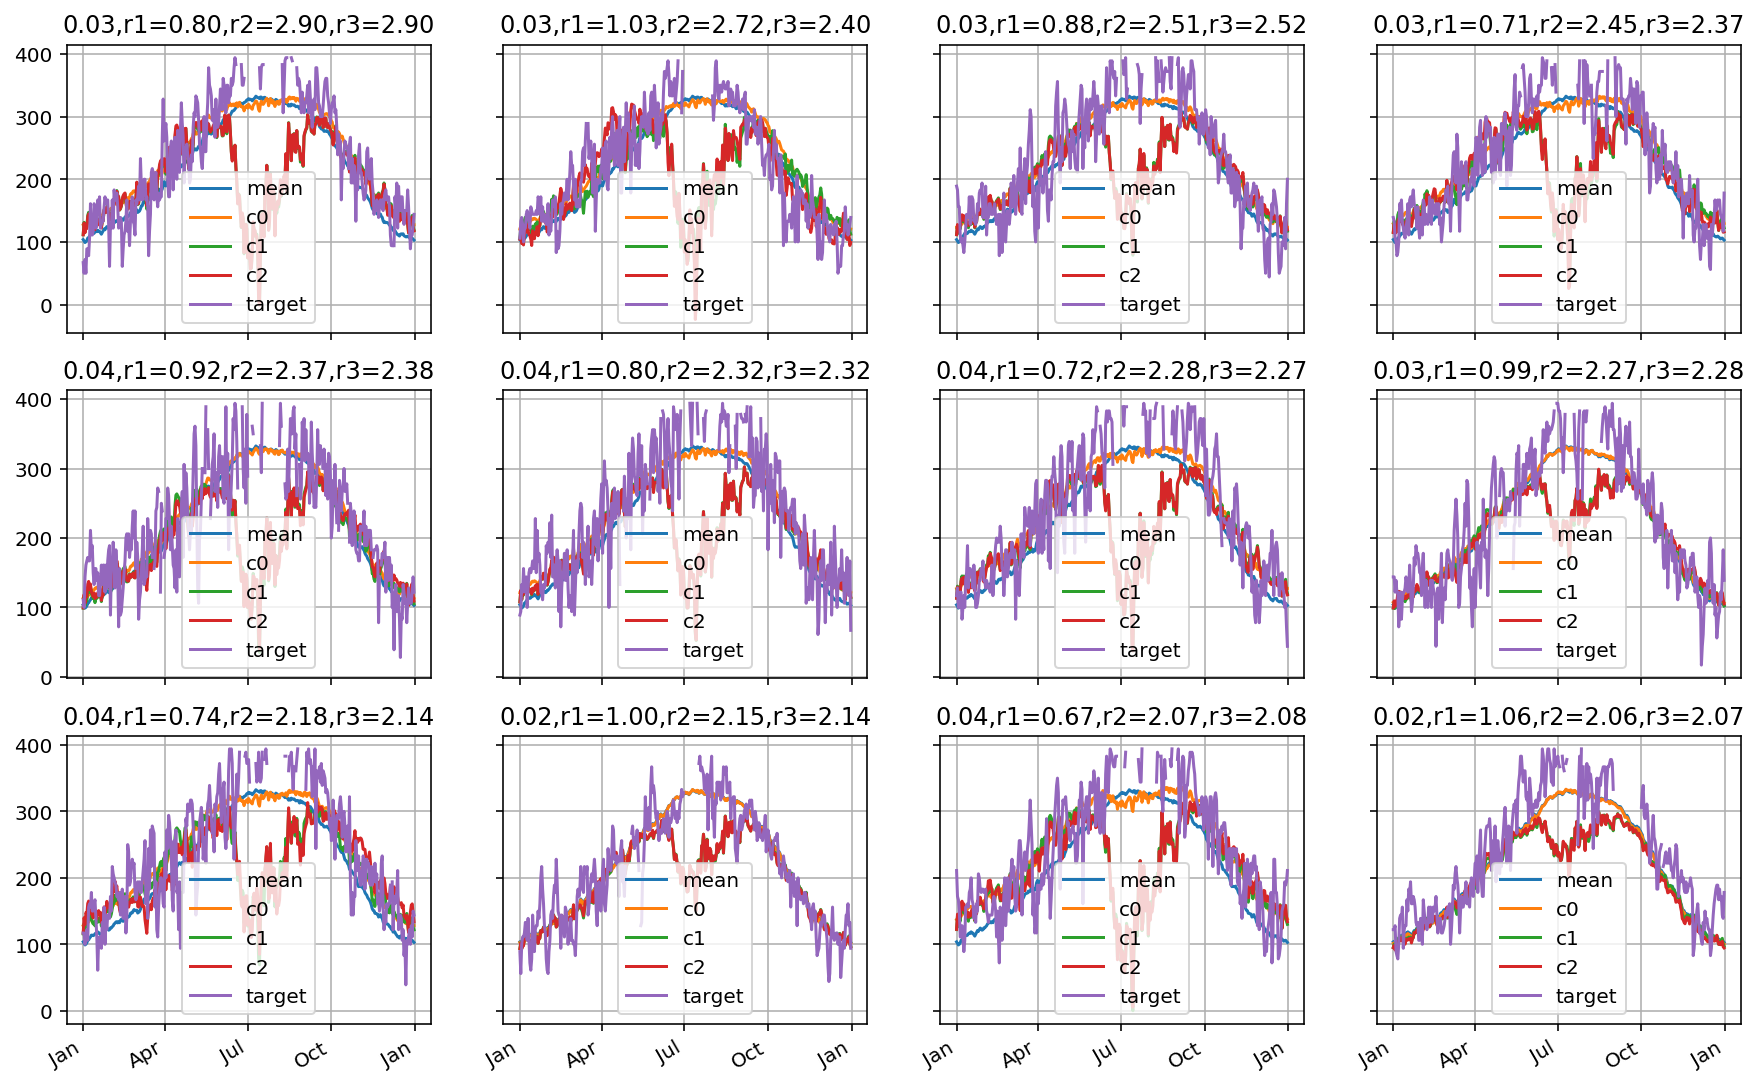

In [64]:
plot_recon_grid(rows)

In [65]:
df3=df3.sort(df3.res_3)
rows=df3.take(num)
df3.select('res_mean','res_1','res_2','res_3').show(4)

+-------------------+-------------------+-------------------+-------------------+
|           res_mean|              res_1|              res_2|              res_3|
+-------------------+-------------------+-------------------+-------------------+
| 0.5014709064403187| 0.3181001516000303| 0.0706828863563467|0.07050803275944421|
|0.45994445270308343|0.25459494543574046| 0.0729429492001073|0.07274134398454164|
| 0.5634220200895198| 0.2724742363767796|0.09882593716899182| 0.0975656791209643|
|0.28487258184791486|0.23816917469148932| 0.1104506019273177|0.10986098504594669|
+-------------------+-------------------+-------------------+-------------------+
only showing top 4 rows



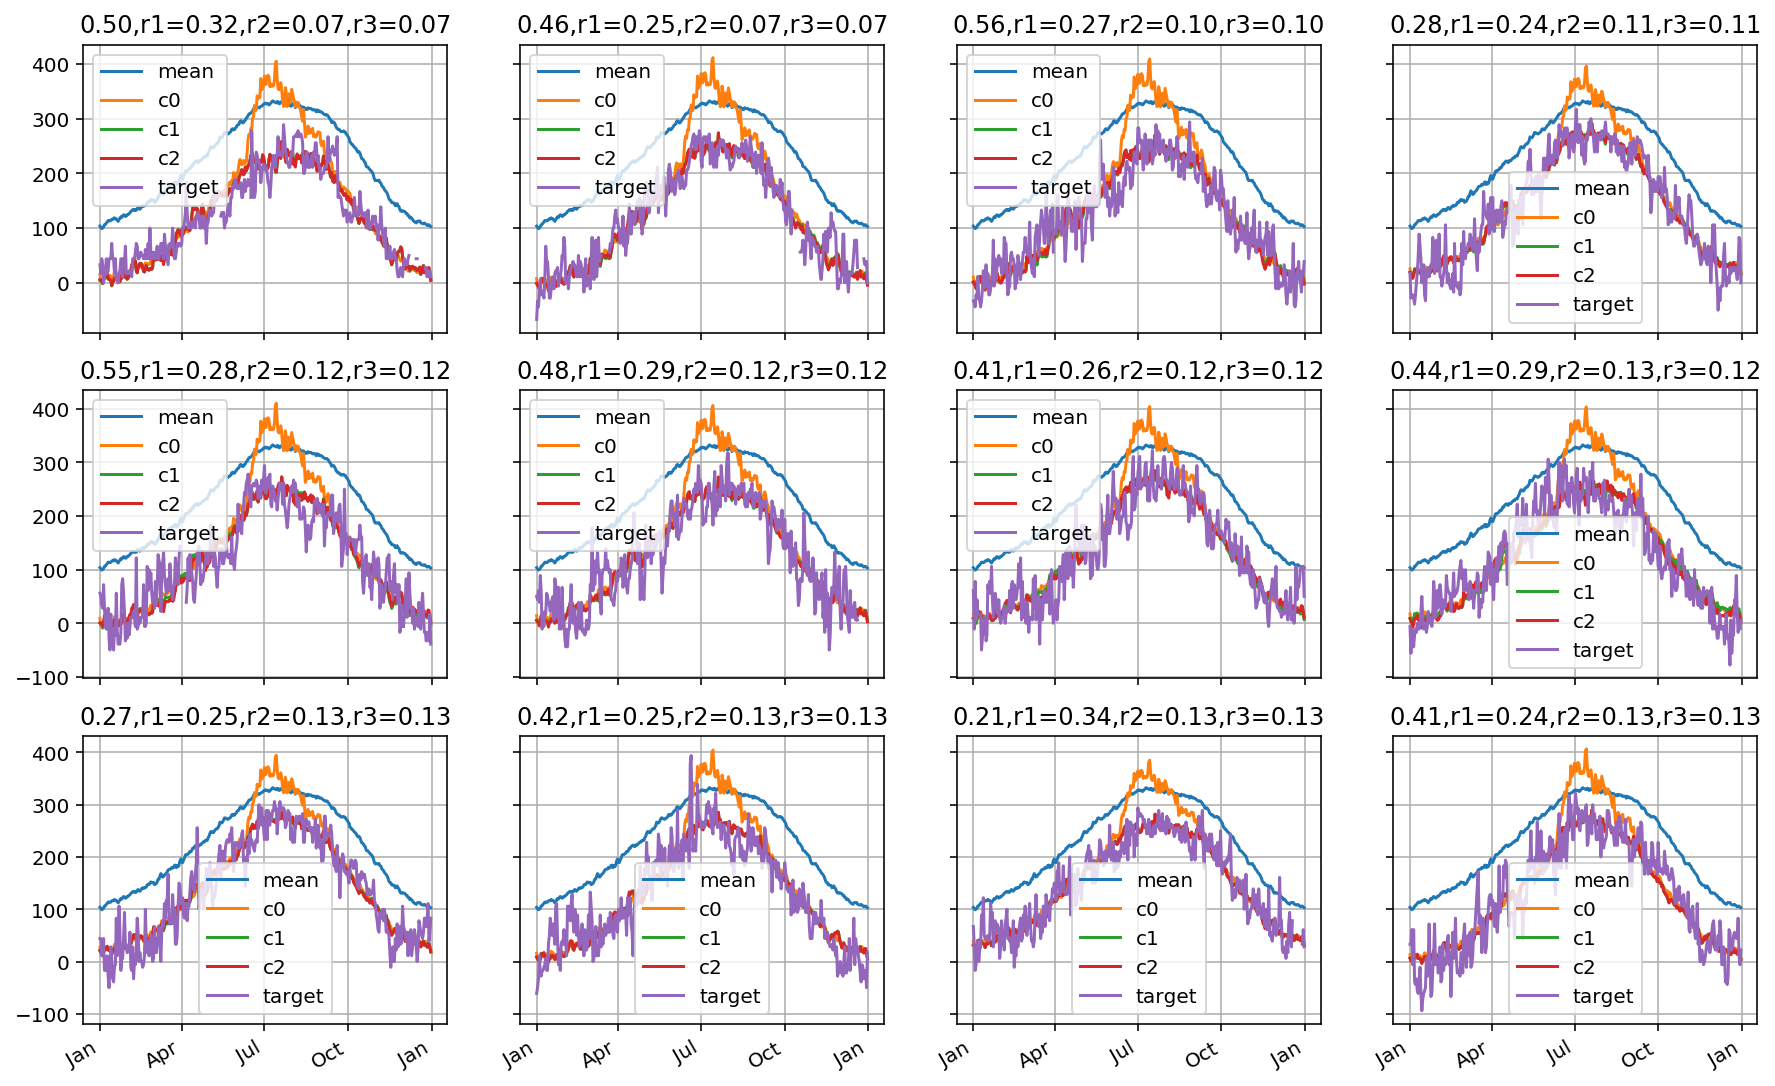

In [66]:
plot_recon_grid(rows)

In [67]:
df3=df3.sort(df3.res_3,ascending=False)
rows=df3.take(12)
df3.select('res_mean','res_1','res_2','res_3').show(4)

+--------------------+------------------+------------------+------------------+
|            res_mean|             res_1|             res_2|             res_3|
+--------------------+------------------+------------------+------------------+
|0.029431963567291518|0.7962757836947854| 2.902176743294988|2.9005965135398957|
|0.031525008520505785|0.8833092175087011|2.5113644996649716| 2.517123061356871|
| 0.02942615222565886|1.0294528136814287|2.7151853073172387|2.4028059930360315|
| 0.03589231067878169|0.9153142534656792|2.3735340252418538| 2.376748124608026|
+--------------------+------------------+------------------+------------------+
only showing top 4 rows



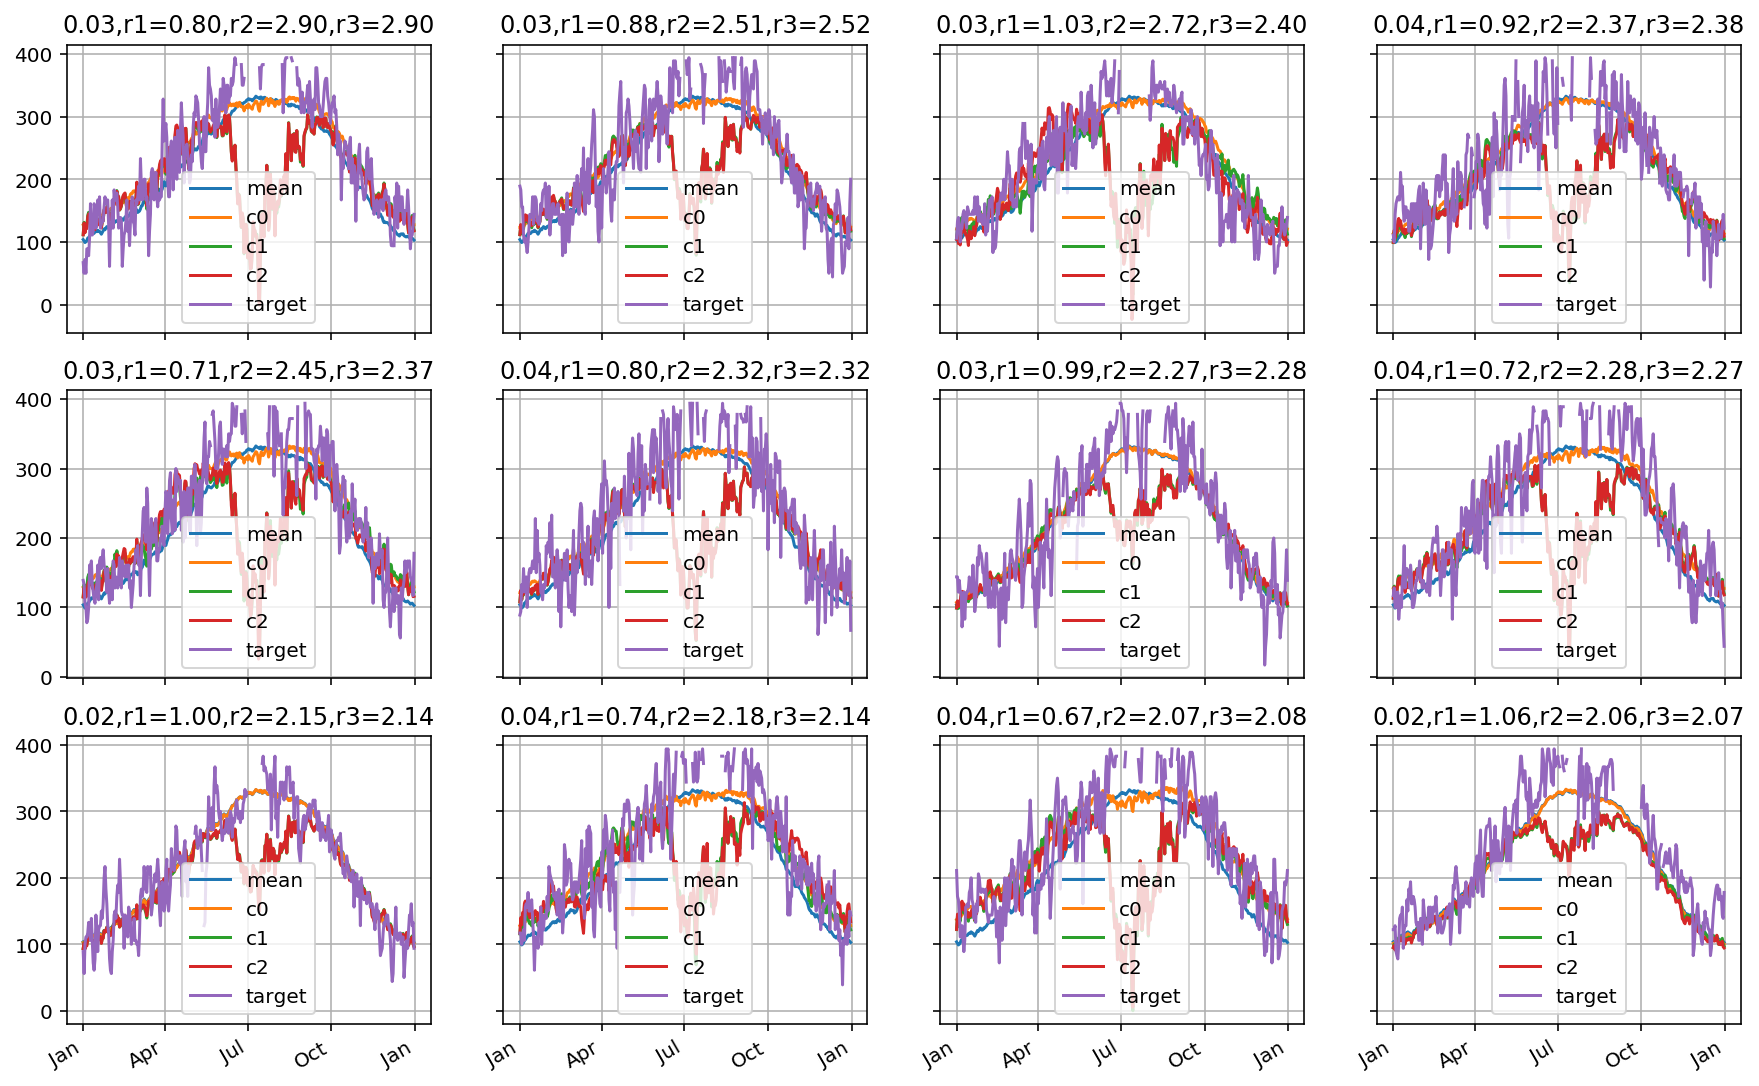

In [68]:
plot_recon_grid(rows)

### How well-explained are the vectors in this collection?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

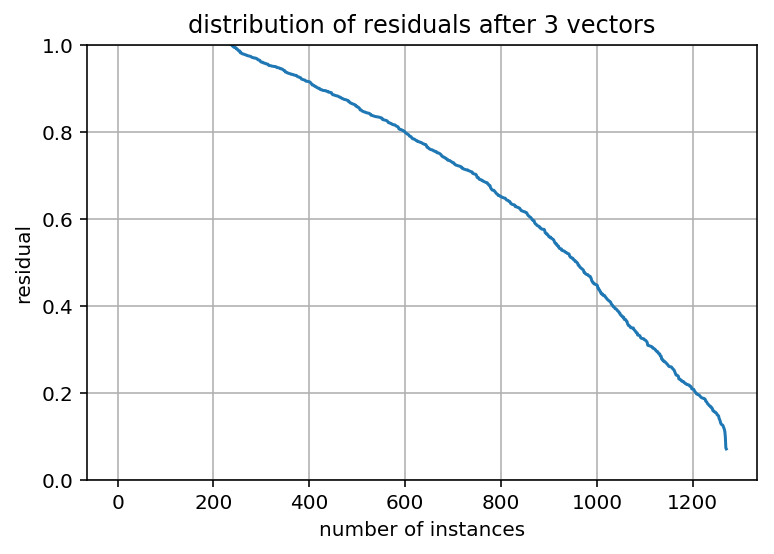

In [35]:
res3=df3.select('res_3').collect()
R3=[r['res_3'] for r in res3]
plot(R3)
title('distribution of residuals after 3 vectors')
xlabel('number of instances')
ylabel('residual')
ylim([0,1])
grid()

In [25]:
filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)

In [26]:
!du -sh $data_dir/*.parquet

2.9M	../../Data/Weather/US_Weather_SSSSSSBB.parquet
3.1M	../../Data/Weather/decon_SSSSSSBB_PRCP.parquet
